<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/LSTM_%ED%95%9C%EB%B2%88%EC%97%90_%ED%95%98%EB%82%98%EC%94%A9_%EC%B6%9C%EB%A0%A5_%EC%98%A4%EC%B0%A8%EC%9C%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from keras.layers import RNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.layers.core import Activation, Dense, Dropout
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [23]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

In [24]:
n_samples = len(df)

In [25]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled_train = df_scaled.loc[:,]
df_scaled_train.columns = scale_cols


In [27]:
train_sc_df = pd.DataFrame(df_scaled_train, columns=['Resistance'], index=df_scaled_train.index)
train_sc_df

,Resistance
0,0.000000
1,0.002915
2,0.005831
3,0.005831
4,0.000000
...,...
250,0.941691
251,0.944606
252,0.953353
253,1.000000


In [28]:
train_feature = train_sc_df['Resistance']
train_label = train_sc_df['Resistance']

In [29]:
train_feature, train_label = make_dataset(train_feature, train_label, 50)

In [30]:
train_feature = train_feature.reshape(train_feature.shape[0], train_feature.shape[1], 1)

In [31]:
train_label = train_label.reshape(train_label.shape[0], 1)


In [32]:
train_feature.shape, train_label.shape

((205, 50, 1), (205, 1))

In [33]:
train_feature, train_label

(array([[[0.        ],
         [0.00291545],
         [0.0058309 ],
         ...,
         [0.06413994],
         [0.06413994],
         [0.06705539]],
 
        [[0.00291545],
         [0.0058309 ],
         [0.0058309 ],
         ...,
         [0.06413994],
         [0.06705539],
         [0.06413994]],
 
        [[0.0058309 ],
         [0.0058309 ],
         [0.        ],
         ...,
         [0.06705539],
         [0.06413994],
         [0.06413994]],
 
        ...,
 
        [[0.55102041],
         [0.55102041],
         [0.55685131],
         ...,
         [0.93877551],
         [0.94169096],
         [0.94460641]],
 
        [[0.55102041],
         [0.55685131],
         [0.56559767],
         ...,
         [0.94169096],
         [0.94460641],
         [0.95335277]],
 
        [[0.55685131],
         [0.56559767],
         [0.57434402],
         ...,
         [0.94460641],
         [0.95335277],
         [1.        ]]]), array([[0.06413994],
        [0.06413994],
        [0.0

In [34]:
model = Sequential()
model.add(LSTM(128, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu')
          )
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
h = model.fit(train_feature, train_label, 
                    epochs=100, 
                    batch_size=1, verbose=2)

Epoch 1/100
205/205 - 3s - loss: 0.0181 - mse: 0.0181
Epoch 2/100
205/205 - 2s - loss: 5.0517e-04 - mse: 5.0517e-04
Epoch 3/100
205/205 - 2s - loss: 6.0167e-04 - mse: 6.0167e-04
Epoch 4/100
205/205 - 2s - loss: 4.7074e-04 - mse: 4.7074e-04
Epoch 5/100
205/205 - 2s - loss: 8.8890e-04 - mse: 8.8890e-04
Epoch 6/100
205/205 - 2s - loss: 4.4599e-04 - mse: 4.4599e-04
Epoch 7/100
205/205 - 2s - loss: 3.3645e-04 - mse: 3.3645e-04
Epoch 8/100
205/205 - 2s - loss: 5.4651e-04 - mse: 5.4651e-04
Epoch 9/100
205/205 - 2s - loss: 2.0743e-04 - mse: 2.0743e-04
Epoch 10/100
205/205 - 2s - loss: 2.6447e-04 - mse: 2.6447e-04
Epoch 11/100
205/205 - 2s - loss: 9.0905e-04 - mse: 9.0905e-04
Epoch 12/100
205/205 - 2s - loss: 3.1501e-04 - mse: 3.1501e-04
Epoch 13/100
205/205 - 1s - loss: 4.7652e-04 - mse: 4.7652e-04
Epoch 14/100
205/205 - 2s - loss: 2.1545e-04 - mse: 2.1545e-04
Epoch 15/100
205/205 - 1s - loss: 3.8244e-04 - mse: 3.8244e-04
Epoch 16/100
205/205 - 1s - loss: 3.8388e-04 - mse: 3.8388e-04
Epoch 17/

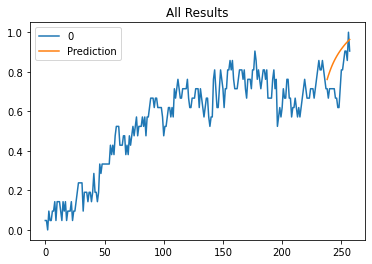

avg =  [13.9385962]


In [37]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

test_df = test_df['Resistance']
lengh = len(test_df)-20
test = test_df.loc[:lengh,]
scale_cols = ['Resistance']

scaler = MinMaxScaler()
test_df = pd.DataFrame(test_df)
test_df.columns = scale_cols

df_scaled_test = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled_test)
df_scaled_test = df_scaled.loc[:lengh,]
# df_scaled_test = df_scaled
df_scaled_test.columns = scale_cols

test_sc_df = pd.DataFrame(df_scaled_test, columns=['Resistance'], index=df_scaled_test.index)

test_feature = test_sc_df['Resistance']
test_label = test_sc_df['Resistance']

test_feature, test_label = make_dataset(test_feature, test_label, 50)
test_feature = test_feature.reshape(test_feature.shape[0], test_feature.shape[1], 1)
test_label = test_label.reshape(test_label.shape[0], 1)

# pred = model.predict(test_feature)
# print(pred)
# print(test_label)
# plt.plot(pred)
# plt.plot(test_label)
# plt.show()


# print(test_feature)
# xhat = test_feature[len(test_feature)-1]
# prediction = model.predict(np.array([xhat]), batch_size=16)
# prediction



all_lengh = 20
xhat = test_feature[len(test_feature)-1]
predictions = np.zeros(all_lengh)

for i in range(all_lengh):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("1", prediction)
  predictions[i] = prediction
  # print("2",predictions)
  xhat=np.vstack([xhat[1:],prediction])
  # print(predictions)

x_list = [] # 미래 30프로 예측 수정중입니다.
for i in range(lengh, lengh+20):
     x_list.append(np.array(i))
df_scaled.plot()
plt.plot(x_list, predictions, label='Prediction')
plt.legend(loc=0)
plt.title('All Results')
plt.show()

error_avg = 0
error = 0

label = test_df['Resistance']
label = pd.DataFrame(label)
label.columns = scale_cols
label_list = scaler.fit_transform(label[scale_cols])

label_list = pd.DataFrame(label_list)
label_list = label_list[len(label_list)-20:].values

for i in range(20):
    error = abs(((predictions[i]-label_list[i]) / predictions[i]) * 100)
    error_avg += error
print("avg = ", error_avg/20)

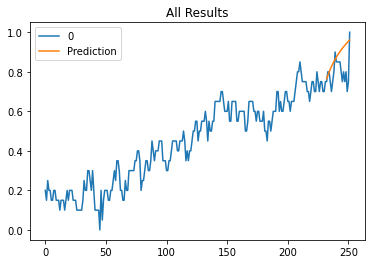

avg =  [9.80400921]


In [38]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

test_df = test_df['Resistance']
lengh = len(test_df)-20
test = test_df.loc[:lengh,]
scale_cols = ['Resistance']

scaler = MinMaxScaler()
test_df = pd.DataFrame(test_df)
test_df.columns = scale_cols

df_scaled_test = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled_test)
df_scaled_test = df_scaled.loc[:lengh,]
# df_scaled_test = df_scaled
df_scaled_test.columns = scale_cols

test_sc_df = pd.DataFrame(df_scaled_test, columns=['Resistance'], index=df_scaled_test.index)

test_feature = test_sc_df['Resistance']
test_label = test_sc_df['Resistance']

test_feature, test_label = make_dataset(test_feature, test_label, 50)
test_feature = test_feature.reshape(test_feature.shape[0], test_feature.shape[1], 1)
test_label = test_label.reshape(test_label.shape[0], 1)

# pred = model.predict(test_feature)
# print(pred)
# print(test_label)
# plt.plot(pred)
# plt.plot(test_label)
# plt.show()


# print(test_feature)
# xhat = test_feature[len(test_feature)-1]
# prediction = model.predict(np.array([xhat]), batch_size=16)
# prediction



all_lengh = 20
xhat = test_feature[len(test_feature)-1]
predictions = np.zeros(all_lengh)

for i in range(all_lengh):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("1", prediction)
  predictions[i] = prediction
  # print("2",predictions)
  xhat=np.vstack([xhat[1:],prediction])
  # print(predictions)

x_list = [] # 미래 30프로 예측 수정중입니다.
for i in range(lengh, lengh+20):
     x_list.append(np.array(i))
df_scaled.plot()
plt.plot(x_list, predictions, label='Prediction')
plt.legend(loc=0)
plt.title('All Results')
plt.show()

error_avg = 0
error = 0

label = test_df['Resistance']
label = pd.DataFrame(label)
label.columns = scale_cols
label_list = scaler.fit_transform(label[scale_cols])

label_list = pd.DataFrame(label_list)
label_list = label_list[len(label_list)-20:].values

for i in range(20):
    error = abs(((predictions[i]-label_list[i]) / predictions[i]) * 100)
    error_avg += error
print("avg = ", error_avg/20)